Import important parameter

In [1]:
inputsize = 387
e = 0.0063

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/4)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 4.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 4.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,4.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,4.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/4)

h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R =  np.matmul(Restriction(int(inputsize/2)),Restriction(inputsize))
P = 4.*np.transpose(R)


In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, 2/3, 1e-12)

Residual = 0.2228011156228324
Interation = 1
Residual = 0.049207907527657906
Interation = 2
Residual = 0.019878416615649173
Interation = 3
Residual = 0.009020488129389976
Interation = 4
Residual = 0.004712755658564283
Interation = 5
Residual = 0.0028075970063199947
Interation = 6
Residual = 0.0018173207575685234
Interation = 7
Residual = 0.0012238807998300825
Interation = 8
Residual = 0.0008381551162365144
Interation = 9
Residual = 0.0005780765504122031
Interation = 10
Residual = 0.0003999966619193963
Interation = 11
Residual = 0.00027724691355168106
Interation = 12
Residual = 0.00019236595005774686
Interation = 13
Residual = 0.00013356866939709017
Interation = 14
Residual = 9.27950081637539e-05
Interation = 15
Residual = 6.449820697107235e-05
Interation = 16
Residual = 4.484864524917389e-05
Interation = 17
Residual = 3.1197144213137606e-05
Interation = 18
Residual = 2.1708776286639465e-05
Interation = 19
Residual = 1.511144407841908e-05
Interation = 20
Residual = 1.0522635663300292e-0

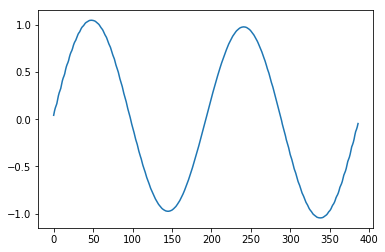

In [6]:
plt.plot(GMM_U)

In [7]:
GMM_Radius = rho(inputsize,A1.to_full(),4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.7459403912577173


Local DMM on fine grid

In [8]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-5,accept_radius = 1 ,step_length = 1e-3, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.002
rho = 0.6699425275342885
L = 0.003
rho = 0.669961440085154
L = 0.004
rho = 0.6717883759034192
L = 0.005
rho = 0.7016913092071873
L = 0.006
rho = 0.6705746665001633
L = 0.007
rho = 0.6911469828698678
L = 0.008
rho = 0.6915105378508154
L = 0.009000000000000001
rho = 0.6912792353640008
L = 0.010000000000000002
rho = 0.6918672687002083
L = 0.011000000000000003
rho = 0.6907987217667109
L = 0.012000000000000004
rho = 0.692873016081716
L = 0.013000000000000005
rho = 0.6888482716227093
L = 0.014000000000000005
rho = 0.6964579452994482
L = 0.015000000000000006
rho = 0.6811121443329814
L = 0.016000000000000007
rho = 0.7079358929809981
L = 0.017000000000000008
rho = 0.6769527249812193
L = 0.01800000000000001
rho = 0.7110369650707659
L = 0.01900000000000001
rho = 0.6831325267302121
L = 0.02000000000000001
rho = 0.7054979441465046
L = 0.02100000000000001
rho = 0.6722816848950852
L = 0.022000000000000013
rho = 0.7048466093503826
L = 0.023000000000000013
rho = 0.671338

L = 0.1220000000000001
rho = 0.6805337850879226
L = 0.1230000000000001
rho = 0.7105224858241171
L = 0.1240000000000001
rho = 0.6805827048833611
L = 0.12500000000000008
rho = 0.7105204324936044
L = 0.12600000000000008
rho = 0.680543583115883
L = 0.12700000000000009
rho = 0.7105260478632286
L = 0.12800000000000009
rho = 0.6805148894066698
L = 0.1290000000000001
rho = 0.7105117900906537
L = 0.1300000000000001
rho = 0.6804623528387458
L = 0.1310000000000001
rho = 0.7104775447903624
L = 0.1320000000000001
rho = 0.6803732603167297
L = 0.1330000000000001
rho = 0.7104128628939933
L = 0.1340000000000001
rho = 0.6802458983630592
L = 0.1350000000000001
rho = 0.7102997622951099
L = 0.1360000000000001
rho = 0.6800397975100689
L = 0.1370000000000001
rho = 0.7101030047845003
L = 0.1380000000000001
rho = 0.6797140915677266
L = 0.1390000000000001
rho = 0.709742330492165
L = 0.1400000000000001
rho = 0.6791384926913848
L = 0.1410000000000001
rho = 0.7089659808915085
L = 0.1420000000000001
rho = 0.6779814

L = 0.2420000000000002
rho = 0.6893405970415821
L = 0.2430000000000002
rho = 0.7247261576008287
L = 0.2440000000000002
rho = 0.6971899203076869
L = 0.2450000000000002
rho = 0.7162515560300813
L = 0.2460000000000002
rho = 0.6818121933033975
L = 0.2470000000000002
rho = 0.6906611554957655
L = 0.2480000000000002
rho = 0.7232573419602633
L = 0.2490000000000002
rho = 0.6943796338772181
L = 0.25000000000000017
rho = 0.7198939995604445
L = 0.25100000000000017
rho = 0.6873165815936967
L = 0.25200000000000017
rho = 0.7232902836331763
L = 0.25300000000000017
rho = 0.6944207758784094
L = 0.25400000000000017
rho = 0.7195900641700657
L = 0.25500000000000017
rho = 0.6869039786989963
L = 0.25600000000000017
rho = 0.7208887421925755
L = 0.2570000000000002
rho = 0.6903952120748296
L = 0.2580000000000002
rho = 0.7195511472046048
L = 0.2590000000000002
rho = 0.6889189067807158
L = 0.2600000000000002
rho = 0.715881906835284
L = 0.2610000000000002
rho = 0.6864300485828205
L = 0.2620000000000002
rho = 0.713

L = 0.36200000000000027
rho = 0.7342341046802745
L = 0.36300000000000027
rho = 0.7065749877114486
L = 0.36400000000000027
rho = 0.7254221105893748
L = 0.36500000000000027
rho = 0.6908866468561697
L = 0.36600000000000027
rho = 0.6939004875703656
L = 0.36700000000000027
rho = 0.7304506875054664
L = 0.36800000000000027
rho = 0.6985747547122693
L = 0.36900000000000027
rho = 0.7346835647920043
L = 0.3700000000000003
rho = 0.7069732536002569
L = 0.3710000000000003
rho = 0.7260934452487329
L = 0.3720000000000003
rho = 0.6914909079369465
L = 0.3730000000000003
rho = 0.6978293315955878
L = 0.3740000000000003
rho = 0.7344250978899441
L = 0.3750000000000003
rho = 0.706296714706314
L = 0.3760000000000003
rho = 0.7275596760013525
L = 0.3770000000000003
rho = 0.6928969128170037
L = 0.3780000000000003
rho = 0.7191393201978215
L = 0.3790000000000003
rho = 0.704434564012212
L = 0.3800000000000003
rho = 0.7312664301497165
L = 0.3810000000000003
rho = 0.6991561312320258
L = 0.3820000000000003
rho = 0.735

L = 0.4830000000000004
rho = 0.7102567732142416
L = 0.4840000000000004
rho = 0.739713677331159
L = 0.4850000000000004
rho = 0.7088078272479029
L = 0.4860000000000004
rho = 0.7410818869847627
L = 0.4870000000000004
rho = 0.7114608909771689
L = 0.4880000000000004
rho = 0.7391810107339045
L = 0.4890000000000004
rho = 0.7073999789866235
L = 0.4900000000000004
rho = 0.7419479248319392
L = 0.4910000000000004
rho = 0.712899727875136
L = 0.4920000000000004
rho = 0.7381850822151625
L = 0.4930000000000004
rho = 0.7051422305917326
L = 0.4940000000000004
rho = 0.740690008332252
L = 0.4950000000000004
rho = 0.7101261034852735
L = 0.4960000000000004
rho = 0.7412897259968756
L = 0.4970000000000004
rho = 0.7111626852576153
L = 0.4980000000000004
rho = 0.7407559213844445
L = 0.4990000000000004
rho = 0.7099573231695137
L = 0.5000000000000003
rho = 0.7418819569725619
L = 0.5010000000000003
rho = 0.7120695524016173
L = 0.5020000000000003
rho = 0.7404711740019658
L = 0.5030000000000003
rho = 0.709082812600

L = 0.6040000000000004
rho = 0.7470491499290436
L = 0.6050000000000004
rho = 0.7160858498489184
L = 0.6060000000000004
rho = 0.7470973646583503
L = 0.6070000000000004
rho = 0.7161039329038037
L = 0.6080000000000004
rho = 0.7471259308563426
L = 0.6090000000000004
rho = 0.7160585535550467
L = 0.6100000000000004
rho = 0.7471209553201944
L = 0.6110000000000004
rho = 0.7159897451002724
L = 0.6120000000000004
rho = 0.747069947789283
L = 0.6130000000000004
rho = 0.7158163381736543
L = 0.6140000000000004
rho = 0.7469033170774534
L = 0.6150000000000004
rho = 0.7154887150560578
L = 0.6160000000000004
rho = 0.7464992764816383
L = 0.6170000000000004
rho = 0.7147730176438684
L = 0.6180000000000004
rho = 0.7452404029068885
L = 0.6190000000000004
rho = 0.7130196383216222
L = 0.6200000000000004
rho = 0.7390216473796636
L = 0.6210000000000004
rho = 0.7152030175243118
L = 0.6220000000000004
rho = 0.7460757253656056
L = 0.6230000000000004
rho = 0.713849577805432
L = 0.6240000000000004
rho = 0.74252348164

L = 0.7250000000000005
rho = 0.7180342814353758
L = 0.7260000000000005
rho = 0.7185548235551915
L = 0.7270000000000005
rho = 0.7318658975907016
L = 0.7280000000000005
rho = 0.7461312740628473
L = 0.7290000000000005
rho = 0.7210676536122682
L = 0.7300000000000005
rho = 0.7479359868867874
L = 0.7310000000000005
rho = 0.7191002663557265
L = 0.7320000000000005
rho = 0.7350951911179312
L = 0.7330000000000005
rho = 0.7421102373611983
L = 0.7340000000000005
rho = 0.7296508933895137
L = 0.7350000000000005
rho = 0.7495863347614828
L = 0.7360000000000005
rho = 0.7188057825896513
L = 0.7370000000000005
rho = 0.7193728113524023
L = 0.7380000000000005
rho = 0.733222859323494
L = 0.7390000000000005
rho = 0.7457105571352964
L = 0.7400000000000005
rho = 0.7236300006073618
L = 0.7410000000000005
rho = 0.7515821964223
L = 0.7420000000000005
rho = 0.7198432207324691
L = 0.7430000000000005
rho = 0.7352534588226741
L = 0.7440000000000005
rho = 0.7434151623166492
L = 0.7450000000000006
rho = 0.7289102032154

L = 0.8470000000000006
rho = 0.7498486789757398
L = 0.8480000000000006
rho = 0.7331514915921449
L = 0.8490000000000006
rho = 0.7555245799249444
L = 0.8500000000000006
rho = 0.7265858751597625
L = 0.8510000000000006
rho = 0.7274428579863744
L = 0.8520000000000006
rho = 0.7419320735962458
L = 0.8530000000000006
rho = 0.7475368998007899
L = 0.8540000000000006
rho = 0.7382780317531957
L = 0.8550000000000006
rho = 0.7524695761687245
L = 0.8560000000000006
rho = 0.7299402711504972
L = 0.8570000000000007
rho = 0.7526231309740156
L = 0.8580000000000007
rho = 0.7299855377083131
L = 0.8590000000000007
rho = 0.7524754064502358
L = 0.8600000000000007
rho = 0.7304734543001075
L = 0.8610000000000007
rho = 0.7533197467323296
L = 0.8620000000000007
rho = 0.7295477293568782
L = 0.8630000000000007
rho = 0.7505011312925556
L = 0.8640000000000007
rho = 0.734345724309064
L = 0.8650000000000007
rho = 0.7559179666094384
L = 0.8660000000000007
rho = 0.7277399967788936
L = 0.8670000000000007
rho = 0.7314846723

L = 0.9680000000000007
rho = 0.7569170592523704
L = 0.9690000000000007
rho = 0.7380040972215547
L = 0.9700000000000008
rho = 0.7568665303461269
L = 0.9710000000000008
rho = 0.7383207708252212
L = 0.9720000000000008
rho = 0.757148334867374
L = 0.9730000000000008
rho = 0.7381607394148951
L = 0.9740000000000008
rho = 0.756837225837835
L = 0.9750000000000008
rho = 0.7388526941449796
L = 0.9760000000000008
rho = 0.7575357760088121
L = 0.9770000000000008
rho = 0.7381011830348227
L = 0.9780000000000008
rho = 0.7564680321765598
L = 0.9790000000000008
rho = 0.7398981613843446
L = 0.9800000000000008
rho = 0.7581819572981461
L = 0.9810000000000008
rho = 0.7377141453287825
L = 0.9820000000000008
rho = 0.7553045716798462
L = 0.9830000000000008
rho = 0.7422234785402275
L = 0.9840000000000008
rho = 0.7583656063374283
L = 0.9850000000000008
rho = 0.7379403419681985
L = 0.9860000000000008
rho = 0.7553509370695477
L = 0.9870000000000008
rho = 0.7426448735913794
L = 0.9880000000000008
rho = 0.75838766979

In [9]:
GLOBALR = Rnew

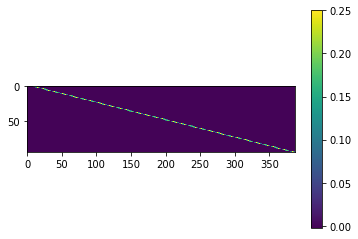

In [10]:
plt.imshow(GLOBALR)
plt.colorbar()

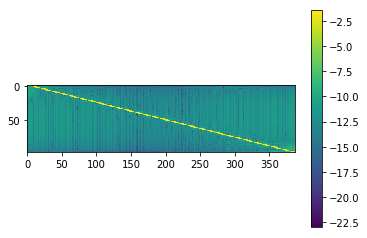

In [11]:
plt.imshow(np.log(np.abs(GLOBALR)))
plt.colorbar()

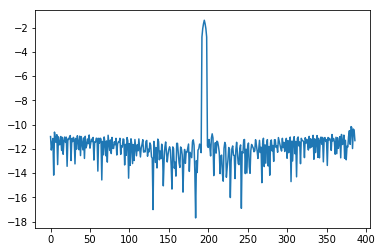

In [12]:
plt.plot(np.log(np.abs(GLOBALR[int(outputsize/2)][:])))

Energy norm: 
0.6657605007105925
L2 norm: 
0.02930157718393195
H1 norm: 
0.48083303734137267
Energy norm: 
0.05288093840327353
L2 norm: 
0.0414386878524386
H1 norm: 
0.053944568855763424
0.7588252926053894


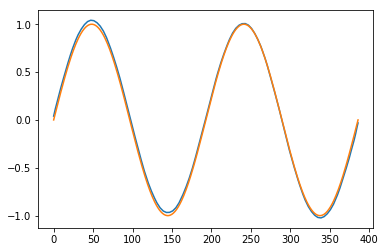

In [13]:
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
GLOBALA = np.zeros([outputsize,outputsize])

for i in range(outputsize):
    for j in range(outputsize):
        basisi = GLOBALR[i][:]
        basisj = GLOBALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        GLOBALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
GLOBALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = GLOBALR[j][:]
        GLOBALF[j][0] = (np.sum(F*basisj))*(H)
        
GLOBALU = np.linalg.solve(GLOBALA,GLOBALF)
GlobalU = np.zeros([inputsize,1])
for i in range(outputsize):
    GlobalU = GlobalU + GLOBALU[i]*GLOBALR[i][:].reshape([inputsize,1])
    
deltaU = GlobalU - Urealfine    
Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)
print(Rhonew)

plt.plot(GlobalU)
plt.plot(Urealfine)